# Freecodecamp Challenge - SMS Text Classification
## with Sentiment Analysis (RNN)
In this challenge, create a machine learning model that will classify SMS messages as either "ham" or "spam". 
- A "ham" message is a normal message sent by a friend. 
- A "spam" message is an advertisement or a message sent by a company.

In [1]:
# setup
# try:
#     %pip install tf-nightly
# except Exception:
#     pass
import tensorflow as tf # tensorflow 2.16.1
import pandas as pd
from tensorflow import keras

# %pip install tensorflow-datasets==4.9.2
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.18.0-dev20240607


## Preparing Data

In [2]:
# get data files
# !wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
# !wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

In [3]:
# create dataframe objects from tsv file
# two ways of doing it

train_dataset = pd.read_table(train_file_path, names=['Type', 'Message'])
test_dataset = pd.read_csv(test_file_path, sep='\t', names=['Type', 'Message'])

In [4]:
train_dataset

,Type,Message
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...
...,...,...
4174,ham,just woke up. yeesh its late. but i didn't fal...
4175,ham,what do u reckon as need 2 arrange transport i...
4176,spam,free entry into our £250 weekly competition ju...
4177,spam,-pls stop bootydelious (32/f) is inviting you ...


In [5]:
test_dataset

,Type,Message
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?
...,...,...
1387,ham,true dear..i sat to pray evening and felt so.s...
1388,ham,"what will we do in the shower, baby?"
1389,ham,where are you ? what are you doing ? are yuou ...
1390,spam,ur cash-balance is currently 500 pounds - to m...


In [6]:
# create labels and features
train_labels, train_features = train_dataset['Type'], train_dataset['Message']
test_labels, test_features = test_dataset['Type'], test_dataset['Message']

## Converting to Numeric Data

In [7]:
# encoding
def bag_of_words(list_of_sentences, word_encoding_integer=1):
    vocab = {} # a set of unique vocabularies in a dataset 
    bag = {} # show how many times a vocabulary appears in a dataset
    encoded_sentences = [] # encoded lines
    
    for sentence in list_of_sentences:
        words_per_sentence = sentence.lower().split(" ") # list the words
        encoded_sentence = []

        for word in words_per_sentence: # for every word in a sentence
            if word in vocab: # if the word is encoded already
                encoded_integer = vocab[word] # get its encoded value
            else: # if the word is new
                vocab[word] = word_encoding_integer # assign the encoded value
                encoded_integer = word_encoding_integer # get its encoded value
                word_encoding_integer += 1 # update encoding value for next word
        
            # if the word is new, assign frequency # if it is old, add frequency
            if encoded_integer in bag: bag[encoded_integer] += 1
            else: bag[encoded_integer] = 1

            encoded_sentence.append(encoded_integer) # convert each line of words into line of encoded integers
      
        encoded_sentences.append(encoded_sentence)
  
    return vocab, bag, encoded_sentences

In [8]:
# decoding
example_vocab = {}
def decode_int(encoded_sentence=[], vocab_name=example_vocab):
    decoded_sentence = ""
    for names, encoded_ints in vocab_name.items(): # iterate through the given set of vocabulary
        for ints in encoded_sentence: # iterate through the encoded values within an encoded sentence
            if encoded_ints == ints: # if each encoded value is in vocab set
                decoded_sentence += " "+str(names) # get its original word
    return decoded_sentence

In [9]:
# encoding the features
# the encoding integer 0 represents lacking of a word, the encoding integer value should start from 1
vocab, vocab_repetition, encoded_sentences = bag_of_words(train_features) # encoding integer value starts from 1, the default
test_vocab, test_vocab_repetition, encoded_test_sentences = bag_of_words(test_features)

# encoding the labels 
# with "sigmoid" activation the encoding integers should be 0 and 1
label_vocab, label_vocab_repetition, encoded_labels = bag_of_words(train_labels,0) # encoding integer value starts from 0
label_test_vocab, label_test_vocab_repetition, encoded_t_labels = bag_of_words(test_labels,0)

In [10]:
# test the functions to features and labels
print(train_features[0]) # original
print(encoded_sentences[0]) # encoded
print(decode_int(encoded_sentences[0], vocab_name=vocab)) # decoded

print()
print(test_features[0]) # original
print(encoded_test_sentences[0]) # encoded
print(decode_int(encoded_test_sentences[0], vocab_name=test_vocab)) # decoded

print()
print(train_labels[0], test_labels[0]) # original
print(encoded_labels[0], encoded_t_labels[0]) # encoded
print(decode_int(encoded_labels[0], vocab_name=label_vocab), decode_int(encoded_t_labels[0], vocab_name=label_test_vocab)) # decoded

ahhhh...just woken up!had a bad dream about u tho,so i dont like u right now :) i didnt know anything about comedy night but i guess im up for it.
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 8, 13, 14, 15, 10, 16, 17, 18, 7, 19, 20, 21, 10, 22, 23, 24, 25, 26]
 ahhhh...just woken up!had a bad dream about about u u tho,so i i i dont like right now :) didnt know anything comedy night but guess im up for it.

i am in hospital da. . i will return home in evening
[1, 2, 3, 4, 5, 6, 1, 7, 8, 9, 3, 10]
 i i am in in hospital da. . will return home evening

ham ham
[0] [0]
 ham  ham


## Data Shape
After both datasets to test and train are encoded, each number should represent a certain vocabulary word. Then-
> - <b>encoded_sentences</b> or <b>encoded_test_sentences</b> should have something like [[1,2,3], [4,5], [1,2,1,3]].

After both labels to test and train are encoded, each number should represent a certain category. In this case there are two categories. 
- 0 for ham message
- 1 for spam message 

Then-
> - <b>encoded_labels</b> or <b>encoded_t_labels</b> should have something like [1,0,0,1,1,0].

## Data Preprocessing
Every sms have different length of words and we cannot pass different lengths. To make each sms the same length:
- If the sms is greater than 80 words, trim off the extra words.
- If the sms is less than 80 words, add 0s till it reaches 80.

Although the cutoff value is arbitrary, here, the average word length of the <b>train_features</b> is used. 
It is calculated by total word counts (including whitespaces) divided by total number of sentences. 

Note: <span style="background:#bebebe; color:black; border-radius:3px; padding: 3px 3px;">sum(vocab_repetition.values())</span> will give the total word counts without whitespaces. Usually, a sentence can have any number of whitespaces, thus the total word counts should include whitespaces counts. 

The function below will find the <b>MAX_LEN</b> as mentioned above.

In [11]:
# Finding MAX_LEN by the average word length
def find_MAX_LEN(list_of_sentences):
    total_word_counts=0
    for i in list_of_sentences:
        total_word_counts+=len(i)
    
    return total_word_counts // len(list_of_sentences)

MAX_LEN = find_MAX_LEN(train_features)
MAX_LEN

80

In [12]:
# variables
MAX_LEN = 80 
BATCH_SIZE = 64
VOCAB_SIZE = len(vocab) #11331
epochs = 10 

In [13]:
# preprocessing the data

# make every sentence the same length
train_data = keras.utils.pad_sequences(encoded_sentences, MAX_LEN)
test_data = keras.utils.pad_sequences(encoded_test_sentences, MAX_LEN)

# flatten the nested list in labels for the model
encoded_train_labels = [eachVal for eachList in encoded_labels for eachVal in eachList]
encoded_test_labels = [eachVal for eachList in encoded_t_labels for eachVal in eachList]

# convert to numpy format
train_data = np.array(train_data)
test_data = np.array(test_data)
encoded_train_labels = np.array(encoded_train_labels)
encoded_test_labels = np.array(encoded_test_labels)

## RNN Model

In [14]:
# build the model
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(VOCAB_SIZE+1, 32),
                             tf.keras.layers.LSTM(32),
                             tf.keras.layers.Dense(1, activation="sigmoid")
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
# compile
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=['accuracy'])

In [16]:
# train
history = model.fit(train_data, encoded_train_labels, epochs=epochs, validation_split=0.2)

Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8675 - loss: 0.3754 - val_accuracy: 0.9474 - val_loss: 0.1511
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9632 - loss: 0.1305 - val_accuracy: 0.9809 - val_loss: 0.0832
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9812 - loss: 0.0698 - val_accuracy: 0.9844 - val_loss: 0.0566
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9897 - loss: 0.0385 - val_accuracy: 0.9833 - val_loss: 0.0513
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9922 - loss: 0.0342 - val_accuracy: 0.9844 - val_loss: 0.0511
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9950 - loss: 0.0215 - val_accuracy: 0.9785 - val_loss: 0.0605
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9967 - loss: 0.0191 - val_accuracy: 0.9868 - val_loss: 0.0549
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9973 - loss: 0.0101 - val_accu

In [17]:
# evaluate
results = model.evaluate(test_data, encoded_test_labels)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6263 - loss: 1.8082


## Plot the Loss and the Accuracy

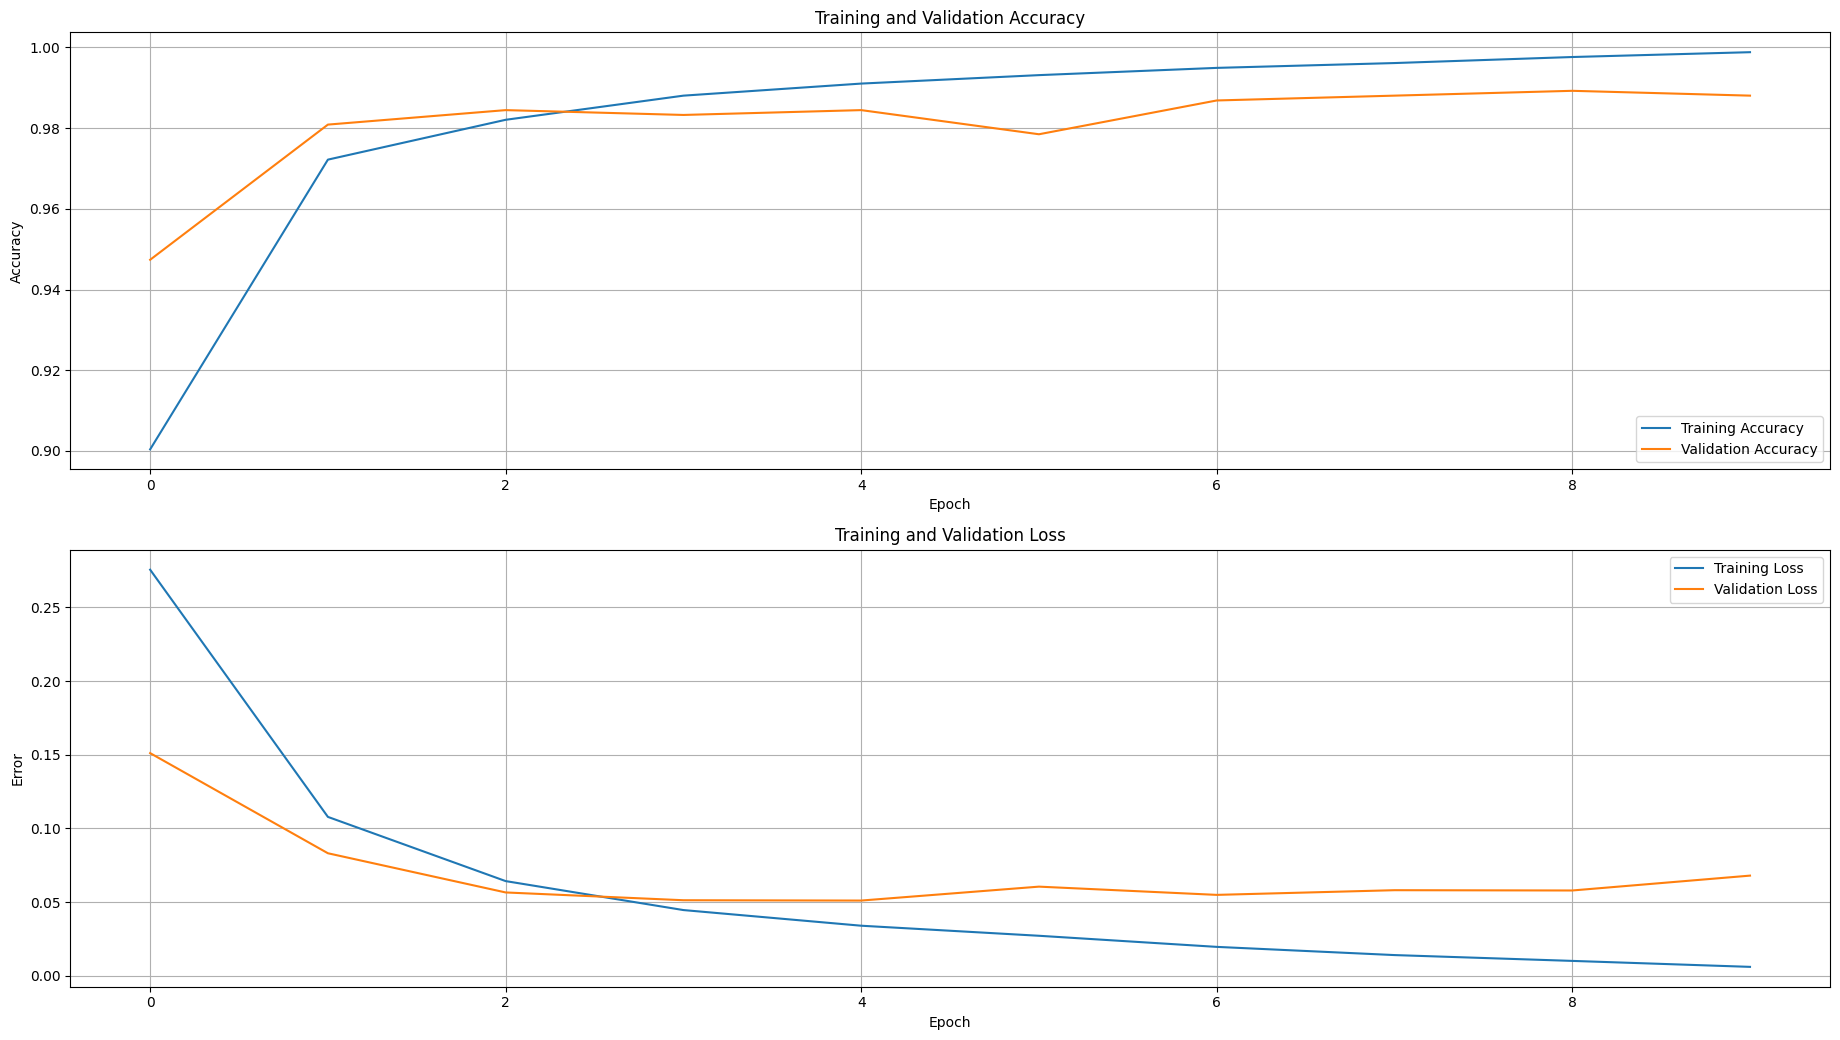

In [18]:
# plot function
def plot_loss_and_acc():
    fig, axs = plt.subplots(2 , 1)
    fig.set_size_inches(18.5, 10.5)
    axs1 = axs[0]
    axs2 = axs[1]

    axs1.plot(range(epochs), history.history['accuracy'], label='Training Accuracy')
    axs1.plot(range(epochs), history.history['val_accuracy'], label='Validation Accuracy')
    axs1.legend(loc='lower right')
    axs1.set(xlabel='Epoch', ylabel='Accuracy')
    axs1.set_title('Training and Validation Accuracy')
    axs1.grid(True)


    axs2.plot(range(epochs), history.history['loss'], label='Training Loss')
    axs2.plot(range(epochs), history.history['val_loss'], label='Validation Loss')
    axs2.legend(loc='upper right')
    axs2.set(xlabel='Epoch', ylabel='Error')
    axs2.set_title('Training and Validation Loss')
    axs2.grid(True)
    fig.tight_layout()
    plt.show()

plot_loss_and_acc()

## Predictions

In [19]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])

def predict_message(pred_text):
    prediction = []
    tokens = keras.preprocessing.text.text_to_word_sequence(pred_text)
    tokens = [vocab[word] if word in vocab else 0 for word in tokens]
    encoded_pred_text = keras.utils.pad_sequences([tokens], MAX_LEN)[0] # numpy object

    pred = np.zeros((1, MAX_LEN))
    pred[0] = encoded_pred_text

    predicted_array = model.predict(pred)
    predicted_val = predicted_array[0].tolist()[0]
    prediction.append(predicted_val)
  
    if predicted_val<0.5:
        prediction.append("ham")
    elif predicted_val>=0.5:
        prediction.append("spam")

    return prediction

# test the function
pred_text = "how are you doing today?"
prediction = predict_message(pred_text)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
[0.00016232124471571296, 'ham']


In [20]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
    test_messages = ["how are you doing today",
                     "sale today! to stop texts call 98912460324",
                     "i dont want to go. can we try it a different day? available sat",
                     "our new mobile video service is live. just install on your phone to start watching.",
                     "you have won £1000 cash! call to claim your prize.",
                     "i'll bring it tomorrow. don't forget the milk.",
                     "wow, is your arm alright. that happened to me one time too"
                    ]

    test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
    passed = True

    for msg, ans in zip(test_messages, test_answers):
        prediction = predict_message(msg)
        if prediction[1] != ans:
            passed = False

    if passed:
        print("You passed the challenge. Great job!")
    else:
        print("You haven't passed yet. Keep trying.")

test_predictions()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
You passed the challenge. Great job!


### Predict any SMS
Given an input string of sms, any sms can be predicted to be either "ham" or "spam".

In [21]:
pred_text = str(input("Enter the SMS:"))
prediction = predict_message(pred_text)
response = ["This message is possibly sent by a friend.", "A possible spam message is detected!"]

print(prediction)
print()
if prediction[1] == "ham":
    print(response[0])
else: print(response[1])

Enter the SMS: claim your prize!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[0.948849081993103, 'spam']

A possible spam message is detected!
